In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)
import datetime


In [9]:
# Read the dataset into a pandas dataframe
df1 = pd.read_csv('../../launchit.csv')
df1.head()

# Make a new copy of the dataset_train 
stock_data = df1.copy()

# Drop qualitative columns
stock_data = stock_data.drop(labels=['sector', 'industry', 'country', 'growth_rate', 'target_median_price', 'target_mean_price', 'target_high_price'], axis=1)

# Isolate just 1 TCKR to attempt LSTM process
stock_data = stock_data[stock_data.TCKR == 'VIST']

# Set the Date column as the index
stock_data = stock_data.set_index('Date')
df = stock_data
df.head()

,Open,High,Low,Close,Adj Close,Volume,TCKR
Date,,,,,,,
2019-07-26,8.25,9.24,8.00,9.10,9.10,2499900.0,VIST
2019-07-29,9.23,11.03,9.09,10.00,10.00,777700.0,VIST
2019-07-30,10.21,10.78,10.10,10.10,10.10,697800.0,VIST
2019-07-31,10.14,10.45,10.00,10.02,10.02,305300.0,VIST
2019-08-01,9.99,10.26,9.11,9.40,9.40,529800.0,VIST


1/1 [==============================] - 1s 1s/step


<AxesSubplot:title={'center':'VIST'}, xlabel='Date'>

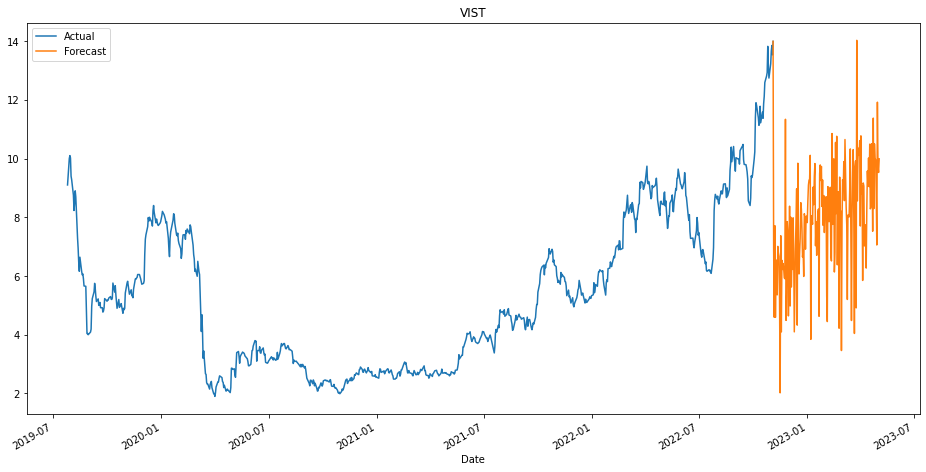

In [10]:
# download the data
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 365  # length of input sequences (lookback period)
n_forecast = 180  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=3, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='VIST', figsize=(16,8))

In [11]:
results.tail()

,Actual,Forecast
Date,,
2023-04-29,NaN,7.055353
2023-04-30,NaN,11.918264
2023-05-01,NaN,9.733211
2023-05-02,NaN,9.526069
2023-05-03,NaN,9.989275
